In [93]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm

# PARAMS TO ADJUST

DBSCAN: 

eps 

number of samples

MIDPOINT

WHERE TO START AND STOP ON AXIS

LAYER WITH PIXELS TO NOT DISPLAY

In [94]:
%matplotlib notebook

In [332]:
root_dir="../data"
SAMPLE_NAME = f"../data/DBS_bG01"
NIFTI_PATH = os.path.join(SAMPLE_NAME,"preop_ct.nii")
nifti = nib.load(NIFTI_PATH)
nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))
GT = np.load(os.path.join(SAMPLE_NAME,"pin_tips.npy"))

In [333]:
for idx, layer in enumerate(nifti_data):
    if np.all((layer == 1)):
        nifti_data[:,:,idx] = np.zeros(nifti_data.shape)

In [340]:
point_cloud = np.array([0,0,0])
for i in range(nifti_data.shape[1]):
    img = nifti_data[:,i,:]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # get their coordinates and attach i
    white_pixels = img>0.98
    white_pixel_coords = np.array(np.where(white_pixels == 1)).transpose(1,0)
    if len(white_pixel_coords)<400:
        point_cloud = np.vstack((point_cloud, np.hstack( (white_pixel_coords, np.ones((white_pixel_coords.shape[0] , 1))*i ))))

<ipython-input-340-8f7d3201da54>:4: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))


<IPython.core.display.Javascript object>


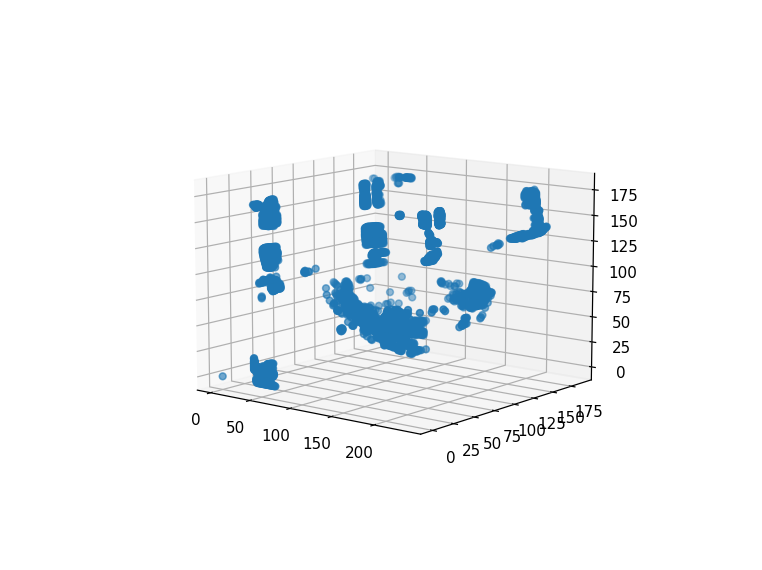

In [341]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], )

In [313]:
from sklearn.cluster import DBSCAN

In [342]:
model = DBSCAN(eps=2, min_samples=5)
model.fit_predict(point_cloud)
pred = model.fit_predict(point_cloud)

<IPython.core.display.Javascript object>


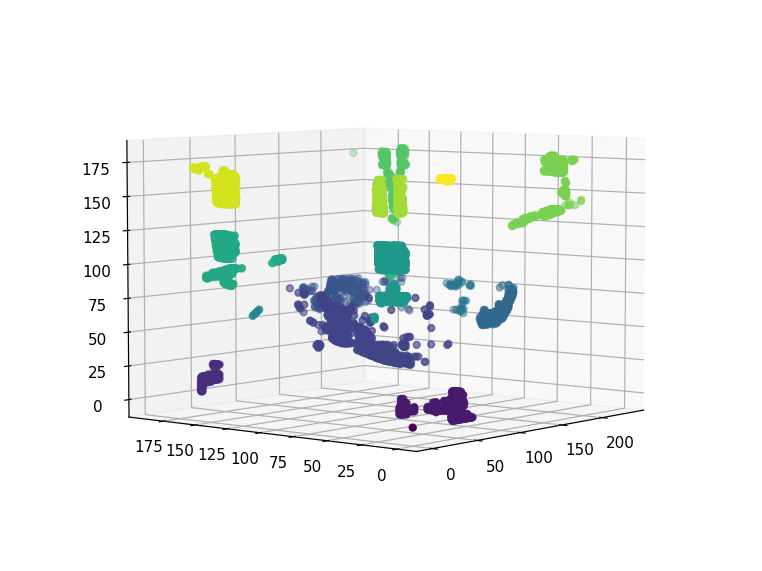

<ipython-input-343-3408862820e1>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [343]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], c=model.labels_, s=20)
ax.view_init(azim=200)
plt.show()

## GET 4 CLUSTERS WITH MOST POINTS

In [316]:
a,b = np.unique(model.labels_, return_counts=True)
sorted_clusters = np.array((a,b)).transpose(1,0)
sorted_clusters=sorted_clusters[sorted_clusters[:,1].argsort()]
l1, l2, l3, l4 = sorted_clusters[-1][0], sorted_clusters[-2][0], sorted_clusters[-3][0], sorted_clusters[-4][0], 

In [317]:
sorted_clusters

array([[ -1,   3],
       [  3,   7],
       [  9,   7],
       [  1,  10],
       [ 11,  11],
       [ 10,  33],
       [  0,  34],
       [ 12,  38],
       [ 13,  43],
       [  2,  54],
       [  6,  58],
       [  8,  60],
       [  7,  63],
       [  4,  99],
       [  5, 309]], dtype=int64)

In [318]:
take = (model.labels_==l1) | (model.labels_==l2) |  (model.labels_== l3) |(model.labels_== l4)

<IPython.core.display.Javascript object>


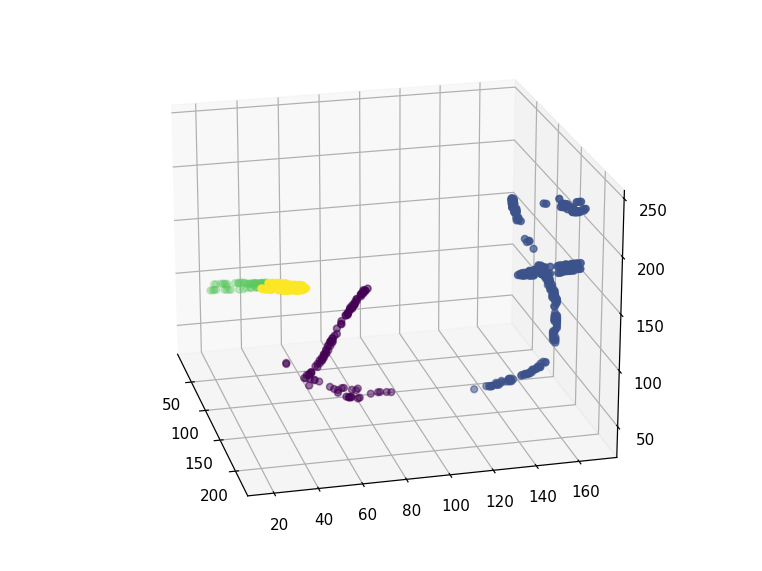

<ipython-input-319-1b68562674f7>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [319]:
new_pc = point_cloud[take]
new_labels = model.labels_[take]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(new_pc[:,0], new_pc[:,1], new_pc[:,2],s=20, c= new_labels)

ax.view_init(azim=200)
plt.show()

In [320]:
def dist(x,y):
    return np.sqrt(np.sum( (x-y)**2))

In [321]:
all_labels = np.unique(new_labels)
min_points = []
for lab in all_labels:
    cluster = new_pc[new_labels==lab]
    # among all points in the cluster find the point closest to
    midpoint = (128, 128, 88)
    min_dist = np.inf
    min_point = ()
    for p in cluster:
        if dist(p, midpoint) < min_dist:
            min_dist = dist(p,midpoint)
            min_point=p
    min_points.append(min_point)
min_points = np.array(min_points)

<IPython.core.display.Javascript object>


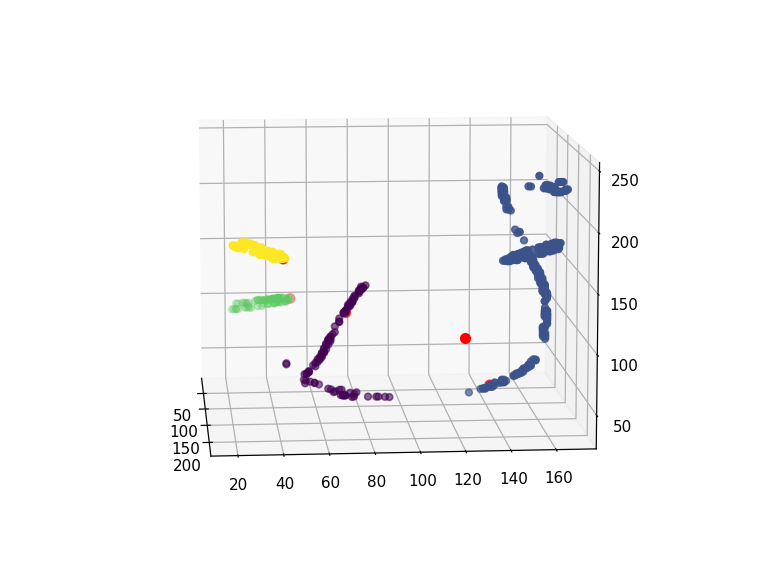

<ipython-input-322-ed2e429372c5>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [322]:
new_pc = point_cloud[take]
new_labels = model.labels_[take]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(new_pc[:,0], new_pc[:,1], new_pc[:,2],s=20, c= new_labels)
ax.scatter(midpoint[0], midpoint[1], midpoint[2], s=40, c='r')
ax.scatter(min_points[:,0], min_points[:,1], min_points[:,2],s=40, c='r')
ax.view_init(azim=200)
plt.show()

In [323]:
min_points

array([[122.,  73., 110.],
       [159., 137.,  55.],
       [ 49.,  50., 106.],
       [186.,  42., 171.]])

In [324]:
def from_hull_to_ct_coords(ct_coords, nifti):
    """
    Converts the coordinates from the hull to the coordinates of the CT scan
    Args:
        ct_coords np.ndarray float (N,3)
        nifti nibabel.nifti1.Nifti1Image  
    Returns
        ct_coords np.ndarray float (N,3)
    """
    Tmatrix = np.transpose(np.linalg.inv(nifti.affine))
    ct_coords = np.hstack((ct_coords, np.ones((ct_coords.shape[0],1)))) @ Tmatrix
    return ct_coords[:,0:3]
 

In [325]:
import itertools
def accuracy(predictions, ground_truth):
    """
        predictions nd.array nx3
        ground_truth nd.array nx3
    """
    pred_perm = np.zeros_like(predictions)
    dsts = []
    perms = list(itertools.permutations([0, 1, 2, 3]))
    for perm in perms:
        pred_perm[0], pred_perm[1], pred_perm[2], pred_perm[3] = \
        predictions[perm[0]], predictions[perm[1]], predictions[perm[2]], predictions[perm[3]]
        dsts.append(np.mean(np.sqrt( np.sum((pred_perm-ground_truth)**2, axis=1 ))))
    return np.min(dsts)

In [326]:
min_points

array([[122.,  73., 110.],
       [159., 137.,  55.],
       [ 49.,  50., 106.],
       [186.,  42., 171.]])

In [327]:
print("PREDICTED POINTS ARE")
predictions =  np.transpose(np.array([min_points[:,0], min_points[:,2], min_points[:,1]]))
predictions

PREDICTED POINTS ARE


array([[122., 110.,  73.],
       [159.,  55., 137.],
       [ 49., 106.,  50.],
       [186., 171.,  42.]])

In [328]:
print("Ground Truth is")
from_hull_to_ct_coords(GT, nifti)

Ground Truth is


array([[186., 170.,  44.],
       [ 49., 107.,  51.],
       [ 53., 102., 140.],
       [191., 168., 140.]])

In [329]:
accuracy(predictions, from_hull_to_ct_coords(GT, nifti))

54.41031549326054

COMPARE TO BASELIUNE MDOEL!
